In [1]:
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
from torchvision import transforms

import pickle

from xmljson import badgerfish as bf
from xml.etree.ElementTree import fromstring

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = '/Users/haohe/Documents/HKUST/competition/data/VisDrone2021-COUNTING/DroneRGBT'
train_images = path + '/Train/RGB'
train_images_TIR = path + '/Train/TIR'
anno = path + '/Train/GT_'
dmap_folder = path + '/Train/DMAP'

In [3]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(12, 12))

        ax[0].imshow(image)
        ax[1].imshow(mask)
        print(mask.sum())
    else:
        f, ax = plt.subplots(2, 2, figsize=(12, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        #print(mask.sum())
        
        
def plot_data(img,points,fig_size=(18,12)):
    p_img = img.copy()
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    for point in points:
        cv2.circle(p_img, tuple(point), radius=0,color=(0, 1, 0), thickness=5)
    ax.imshow(p_img)

In [4]:
def get_train_transforms():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ],
)

def get_train_image_only_transforms():
    return A.Compose(
        [
            A.RandomBrightnessContrast(brightness_limit=0.2, 
                                       contrast_limit=0.2, p=0.5),
            A.Blur(blur_limit=3,p=0.2),
        ],
        additional_targets={'image': 'image'}
    )

# def get_valid_trainsforms():
#     return A.Compose(
#         [
#             #A.Resize(360,640,interpolation=2),
#             A.Normalize(mean=mean,std=std,p=1.0,max_pixel_value=1.0),
#             ToTensorV2(p=1.0),
#         ]
#     )

In [51]:
class Video_Counting_Dataset(Dataset):
    def __init__(self,path,images_folder,dmap_folder,
                 seq_len=5,gt_folder=None,suffix='jpg',
                 tfms=None,mosaic=False,
                 sample=0,segment=5,num_sample=5):
        super().__init__()
        
        self.path = path
        self.images_path = path + images_folder
        self.image_fnames = glob(self.images_path+f'/*.{suffix}')
        
        # TODO:
        # Be able to get sequences
        
        self.image_fnames = sorted(self.image_fnames,key=lambda x: int(x.split('/')[-1].split('.')[0]))
        self.dmap_folder = path + dmap_folder
        self.seq_len = seq_len
        self.transforms = tfms
        self.mosaic = mosaic
        self.gt_folder = path + gt_folder # test purpose
        self.sample = sample # 0 is consective, 1 is TSN
        self.segment = segment
        self.num_sample = num_sample
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])
        self.item_tfms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean,std=self.std),
        ])
        
    def __len__(self):
        return len(self.image_fnames)
    
    def __getitem__(self, idx):
        '''
            Get a sequence of frames
            Return: 
                frames, shape: seq, h,w,c
                dmaps, shape: seq, h,w
                gt_points, seq_len of each frame
        '''
        if self.sample: # TSN sampling
            frames,dmaps,fns,gt_points = self._tsn_sampling(idx)
        else:
            frames,dmaps,fns,gt_points = self._consective_sampling(idx)
            
        if not isinstance(self.transforms,type(None)):
            t,ch,h,w = frames.shape
            frames = frames.view(t*ch,h,w).permute(1,2,0).numpy()
            dmaps = dmaps.permute(1,2,0).numpy()
            for tfms in self.transforms:
                aug = tfms(**{
                    'image': frames,
                    'mask': dmaps
                })
            # TODO reshape
                frames, dmaps = aug['image'], aug['mask']
            frames = torch.from_numpy(frames).permute(2,0,1).view(t,ch,h,w)
            dmaps = torch.from_numpy(dmaps).permute(2,0,1)
        return frames, dmaps, fns, gt_points
    
    def _tsn_sampling(self,idx):
        '''
        Note:
        This method broadly corresponds to the frame sampling technique
        introduced in ``Temporal Segment Networks`` at ECCV2016
        https://arxiv.org/abs/1608.00859.
        
        Note: 
        Minor changes:
        1) When frames don't have enough to sample, resample at the given region until we reach segments
            pitfall: if last idx is passed, then tsn sampling will duplicate segment times of last frame
        2) offset index when we have enough frames
        
        Args: 
            idx: call by __getitem__
        
        Returns:
            List of frames sampled in tensor
            List of density maps sampled in tensor
            List of file names
            List of point annotation
        '''
        
        frames, d_maps, fns, gt_points = [],[],[],[]
        length = self.segment * self.num_sample
        start_frame = idx
        
        # Edge case when we don't have enough to sample, result repeated frames
        if start_frame + length > self.__len__():
            idxs = np.sort(np.random.randint(start_frame,self.__len__(),self.segment))
        
        # Sample segment times, sampling gap equals to num_sample
        else:
            end_frame = start_frame + length - 1
            idxs = (np.arange(start_frame,end_frame+1,self.num_sample)
                    + np.random.randint(self.num_sample,size=self.segment))
        for idx in idxs:
            fn = self.image_fnames[idx]
            image,dmap,points = self._load_one_frame(fn)
            frames.append(image)
            d_maps.append(dmap)
            fns.append(fn)
            gt_points.append(points)
        return torch.stack(frames),torch.stack(d_maps),fns,np.array(gt_points)
    
    def _consective_sampling(self,idx):
        '''
        Choose consective frames from given positin idx
        
        Args:
            idx: call by __getitem__
            
        Returns:
            List of frames sampled in tensor
            List of density maps sampled in tensor
            List of file names
            List of point annotation
        '''
        frames, d_maps, fns, gt_points = [],[],[],[]
        frame_diff = self.__len__() - idx
        if frame_diff >= self.seq_len:
            start_frame = idx
        elif frame_dff < self.seq_len:
            # random back off when sampling dont have enough samples
            idx -= frame_diff
            start_frame = round((idx - frame_diff) * np.random.rand())
        else:
            raise ValueError('start_frame init error...')
        for n in range(idx,idx+self.seq_len):
                fn = self.image_fnames[n]
                image,dmap,points = self._load_one_frame(fn)
                frames.append(image)
                d_maps.append(dmap)
                fns.append(fn)
                gt_points.append(points)
        
        return torch.stack(frames),torch.stack(d_maps),fns,np.array(gt_points)
    
    def _load_one_frame(self,fn):
        y_fn, p_fn = self._prepare_fn(fn)
        image = cv2.imread(fn)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.
        image = self.item_tfms(image)
        d_map, points = self._get_gts(y_fn,p_fn)
        d_map = torch.from_numpy(d_map)
        return image, d_map, points
    
    def _prepare_fn(self,fn):
        file_name = fn.split('/')[-1].split('.')[0]
        y_fn = self.dmap_folder + '/' + file_name + 'Dmap.pkl'
        p_fn = self.gt_folder + '/' + file_name + 'R.xml'
        return y_fn, p_fn
    
    def _get_gts(self,y_fn,p_fn):
        d_map = np.load(y_fn,allow_pickle=True)
        if not self.gt_folder:
            return (None,0)
        with open(p_fn,'r') as f:
                data = f.read()
        test_data = bf.data(fromstring(data))
        points = self._get_annotation(test_data)
        return d_map, points
        
    def _get_annotation(self,xml_datas):
        points = []
        for data in xml_datas['annotation']['object']:
            if data['name']['$'] == 'person' or data['name']['$'] == 'person]':
                if 'point' in data:
                    x = data['point']['x']['$']
                    y = data['point']['y']['$']
                else:
                    x = data['bndbox']['xmin']['$']
                    y = data['bndbox']['ymin']['$']
                points.append((x,y))
            else: print(data['name']['$'] +' not a person...')
        return np.array(points,dtype=np.int)
    
    def _normalize(self,img):
        img -= self.mean[None,None,...]
        img /= self.std[None,None,...]
        return img

In [52]:
train_dataset = Video_Counting_Dataset(path=path,
                                       images_folder='/Train/RGB',dmap_folder='/Train/DMAP',
                                       gt_folder='/Train/GT_',
                                       tfms=[get_train_transforms(),get_train_image_only_transforms()],
                                       sample = 0
)

In [53]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
def denoramlize(img):
    return img * std[...,None,None] + mean[...,None,None]

In [54]:
def collate_fn(batch):
    frames, dmaps, fns, gt_points = zip(*batch)
    return torch.stack(frames), torch.stack(dmaps), fns, gt_points

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=2,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=0,
        collate_fn=collate_fn,
    )

In [83]:
frames,dmaps,fns,gt_points = next(iter(train_loader))

In [102]:
dmaps * 1000

tensor([[[[8.3211e-03, 8.7356e-03, 9.1747e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.9011e-03, 9.3431e-03, 9.8111e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.5137e-03, 9.9844e-03, 1.0483e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [9.0492e-03, 9.0858e-03, 9.1217e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.9744e-03, 9.0107e-03, 9.0463e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.8994e-03, 8.9354e-03, 8.9707e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[3.9254e-03, 4.0680e-03, 4.2224e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.2329e-03, 4.3871e-03, 4.5540e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.5554e-03, 4.7219e-03, 4.9021e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [8.0665e-03, 8.1031e-03, 8.1391e-03,  ..., 0.0000

In [84]:
frames.shape

torch.Size([2, 5, 3, 512, 640])

In [85]:
gt_points[0].shape

(5,)

In [86]:
i,j = (26, 44)

In [94]:
points = [p_l - [j,i] for p_l in gt_points[0]]

In [88]:
mask = [(p[:,0]>=0) * (p[:,0]<=384) * (p[:,1]>=0) * (p[:,1]<=384) for p in points]

In [92]:
[p[m] for p,m in zip(points,mask)]

[array([[268, 109],
        [235,  36],
        [187,  28],
        [ 28,  15],
        [  6,  40]]),
 array([[  2, 376],
        [266, 111],
        [241,  46],
        [ 31,  15],
        [ 16,  39],
        [185,  35]]),
 array([[ 12, 111],
        [138,  93],
        [203,  36],
        [366,  46],
        [366, 314],
        [365, 335],
        [339, 341],
        [304, 289],
        [294, 276],
        [270, 215],
        [ 98, 277],
        [ 17, 368]]),
 array([[153,  97],
        [120, 118],
        [297,  42],
        [149,  81],
        [133, 270],
        [340, 214],
        [348, 271],
        [343, 283],
        [ 16, 354],
        [373, 322],
        [365, 340],
        [349, 343]]),
 array([[308,  39],
        [349, 218],
        [356, 273],
        [376, 320],
        [352, 285],
        [349, 345],
        [367, 335],
        [140, 270],
        [136, 127],
        [153,  99],
        [ 19, 352],
        [150,  87]])]

In [90]:
mask_test = (points[0][:,0]>=0) * (points[0][:,0]<=384) * (points[0][:,1]>=0) * (points[0][:,1]<=384)

In [91]:
points[0][mask_test]

array([[268, 109],
       [235,  36],
       [187,  28],
       [ 28,  15],
       [  6,  40]])

In [93]:
mask_test

array([False, False, False, False, False, False, False, False,  True,
       False,  True,  True,  True,  True, False])

# Model

In [9]:
"""
ConvLSTM for video-based crowd counting
Reference: Spatiotemporal Modeling for Crowd Counting in Videos, ICCV2017
Link: https://openaccess.thecvf.com/content_ICCV_2017/papers/Xiong_Spatiotemporal_Modeling_for_ICCV_2017_paper.pdf
"""

import torch.nn as nn
import torch
from torchvision import models
import torch.nn.functional as F

class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, args):
        super(ConvLSTM, self).__init__()
        load_weights = True
        hdim=64

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        self.encoder_1_convlstm = ConvLSTMCell(input_dim=3, # original 3
                                            hidden_dim=128, #64
                                            kernel_size=(3, 3),
                                            bias=True)

        self.encoder_2_convlstm = ConvLSTMCell(input_dim=128, #64
                                            hidden_dim=hdim,
                                            kernel_size=(3, 3),
                                            bias=True)
                                        
        self.decoder_1_convlstm = ConvLSTMCell(input_dim=hdim,
                                            hidden_dim=hdim,
                                            kernel_size=(3, 3),
                                            bias=True)

        self.decoder_2_convlstm = ConvLSTMCell(input_dim=hdim,
                                            hidden_dim=hdim,
                                            kernel_size=(3, 3),
                                            bias=True)
        self.decoder_CNN = nn.Conv3d(in_channels=hdim, # hdim
                                     out_channels=1,
                                     kernel_size=(1, 3, 3),
                                     padding=(0, 1, 1))

 
    def autoencoder(self, x, seq_len, future_step, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4):
        outputs = []
        # encoder
        for t in range(seq_len):
            h_t, c_t = self.encoder_1_convlstm(input_tensor=x[:, t, :, :],
                                               cur_state=[h_t, c_t])  # we could concat to provide skip conn here
            h_t2, c_t2 = self.encoder_2_convlstm(input_tensor=h_t,
                                                 cur_state=[h_t2, c_t2])  # we could concat to provide skip conn here
        # encoder_vector
        encoder_vector = h_t2

        # decoder
        for t in range(future_step):
            h_t3, c_t3 = self.decoder_1_convlstm(input_tensor=encoder_vector,
                                                 cur_state=[h_t3, c_t3])  # we could concat to provide skip conn here
            h_t4, c_t4 = self.decoder_2_convlstm(input_tensor=h_t3,
                                                 cur_state=[h_t4, c_t4])  # we could concat to provide skip conn here
            encoder_vector = h_t4
            outputs += [h_t4]  # predictions

        outputs = torch.stack(outputs, 1)
        outputs = outputs.permute(0, 2, 1, 3, 4)
        outputs = self.decoder_CNN(outputs)
        #outputs = torch.nn.Sigmoid()(outputs)

        return outputs

    def autoencoder2(self, x, seq_len, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4):
        outputs = []
        # encoder
        for t in range(seq_len):
            h_t, c_t = self.encoder_1_convlstm(input_tensor=x[:, t, :, :],
                                               cur_state=[h_t, c_t])  # we could concat to provide skip conn here
            h_t2, c_t2 = self.encoder_2_convlstm(input_tensor=h_t,
                                                 cur_state=[h_t2, c_t2])  # we could concat to provide skip conn here
            h_t3, c_t3 = self.decoder_1_convlstm(input_tensor=h_t2,
                                                 cur_state=[h_t3, c_t3])  # we could concat to provide skip conn here
            h_t4, c_t4 = self.decoder_2_convlstm(input_tensor=h_t3,
                                                 cur_state=[h_t4, c_t4])  # we could concat to provide skip conn here
            encoder_vector = h_t4
            outputs += [h_t4]  # predictions

        outputs = torch.stack(outputs, 1)
        outputs = outputs.permute(0, 2, 1, 3, 4)
        outputs = self.decoder_CNN(outputs)
        outputs = torch.nn.Sigmoid()(outputs)

        return outputs

    def forward(self,x):
        b, seq_len, _, h, w = x.size()

        # initialize hidden states
        h_t, c_t = self.encoder_1_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t2, c_t2 = self.encoder_2_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t3, c_t3 = self.decoder_1_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t4, c_t4 = self.decoder_2_convlstm.init_hidden(batch_size=b, image_size=(h, w))

        # autoencoder forward
        #future_seq = 3
        outputs = self.autoencoder2(x, seq_len, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4)
        
        #outputs = torch.stack(x, 1)
        #outputs = x.permute(0, 2, 1, 3, 4)
        #outputs = self.decoder_CNN(outputs)

        #outputs = F.upsample(outputs, scale_factor=8)
#         output1 = F.upsample(outputs[:,:,0,:,:], scale_factor=8)
#         output2 = F.upsample(outputs[:,:,1,:,:], scale_factor=8)
#         output3 = F.upsample(outputs[:,:,2,:,:], scale_factor=8)
#         output = torch.stack((output1, output2, output3), 1)

        return outputs.squeeze()




In [10]:
model = ConvLSTM(None)

In [11]:
frames,dmaps,fns,gt_points = next(iter(train_loader))

In [12]:
frames.shape

torch.Size([2, 5, 3, 512, 640])

In [13]:
frames[:,0,:,:].shape

torch.Size([2, 3, 512, 640])

In [13]:
preds = model(frames)

In [15]:
preds.shape

torch.Size([2, 5, 512, 640])

In [16]:
nn.MSELoss()(preds,dmaps)

tensor(0.2460, grad_fn=<MseLossBackward>)

In [17]:
preds.sum([-1,-2])

tensor([[162653.5156, 162647.5156, 162617.5312, 162586.0781, 162560.5312],
        [162652.8750, 162645.7188, 162614.6562, 162582.1875, 162555.7812]],
       grad_fn=<SumBackward1>)

In [41]:
dmaps.sum([-1,-2])

tensor([[11.5159, 16.6059, 28.2662, 29.4441, 33.3578],
        [54.8226, 54.6078, 55.1595, 57.3517, 44.8604]])

In [18]:
nn.L1Loss()(preds.sum([-1,-2]),dmaps.sum([-1,-2]))

tensor(162535.0312, grad_fn=<L1LossBackward>)

In [43]:
a = np.array([len(i) for i in gt_points[0]] + [len(i) for i in gt_points[1]]).reshape([2,5])
a

array([[12, 17, 30, 31, 34],
       [56, 56, 56, 59, 47]])

In [52]:
a.astype(np.float32).shape

(2, 5)

In [51]:
dmaps.sum([-1,-2]).numpy().shape

(2, 5)

In [62]:
nn.L1Loss()(torch.from_numpy(a),dmaps.sum([-1,-2]))

tensor(1.2008)

# Test dataloader

In [235]:
frames, dmaps, fns, gt_points = next(iter(train_loader))

In [229]:
frames[0].shape,dmaps[0].shape

(torch.Size([5, 3, 512, 640]), torch.Size([5, 512, 640]))

In [236]:
test_frames = frames[0]
dsum = [i.sum().item() for i in dmaps[0]]
gt_sum = [len(i) for i in gt_points[0]]
dsum,gt_sum

([113.15888977050781,
  110.14826965332031,
  121.17215728759766,
  106.18864440917969,
  122.78630828857422],
 [114, 111, 122, 108, 124])

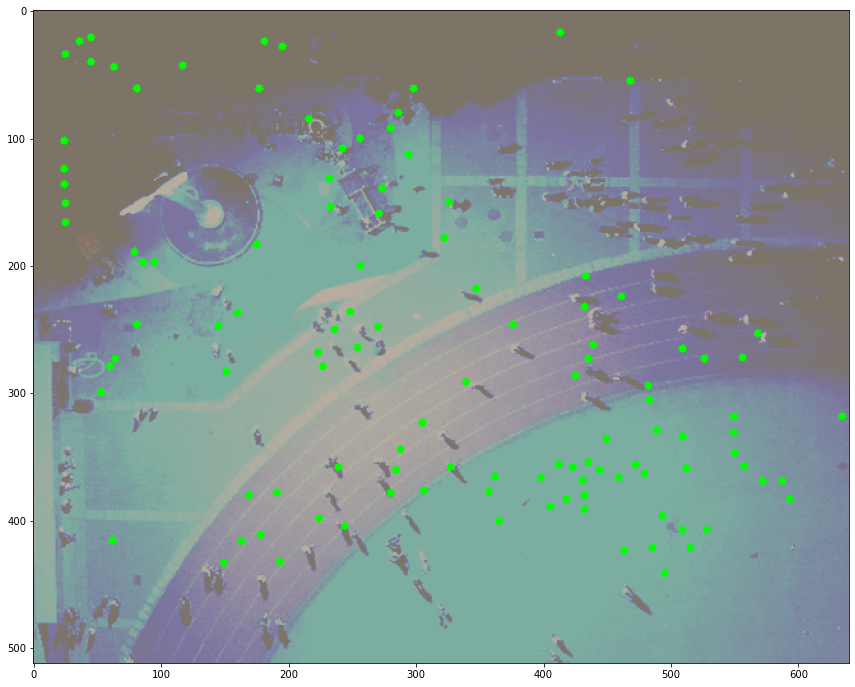

In [247]:
plot_data(denoramlize(test_frames[0]).permute(1,2,0).numpy(),gt_points[0][0])

In [18]:
test_frames = frames[0]
test_frames.shape

torch.Size([16, 3, 512, 640])

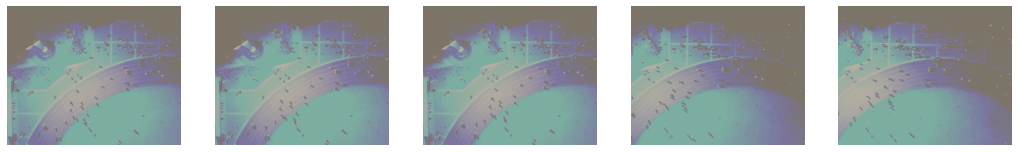

In [239]:
ig, axes = plt.subplots(ncols=5, nrows=1, figsize=(18,12))
for j, x in enumerate(test_frames):
    axes[j].imshow(denoramlize(x).permute(1,2,0).numpy())
    axes[j].axis('off')

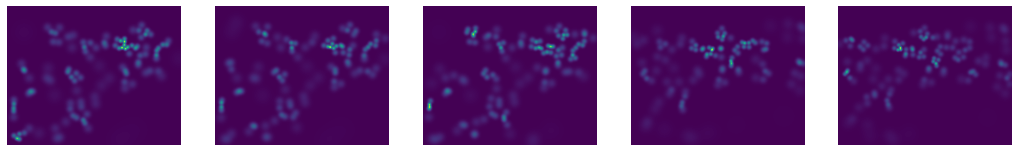

In [246]:
ig, axes = plt.subplots(ncols=5, nrows=1, figsize=(18,12))
for j, x in enumerate(dmaps[0]):
    axes[j].imshow(x.numpy())
    axes[j].axis('off')

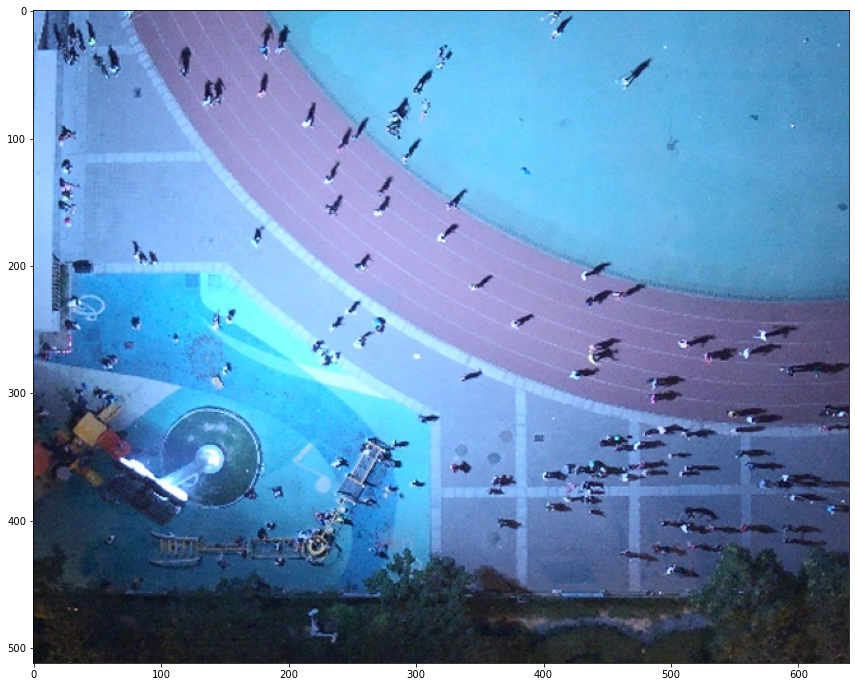

In [241]:
image = cv2.imread(fns[0][0])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
image = image/255.
_,ax = plt.subplots(1,1,figsize=(16,12))
ax.imshow(image)

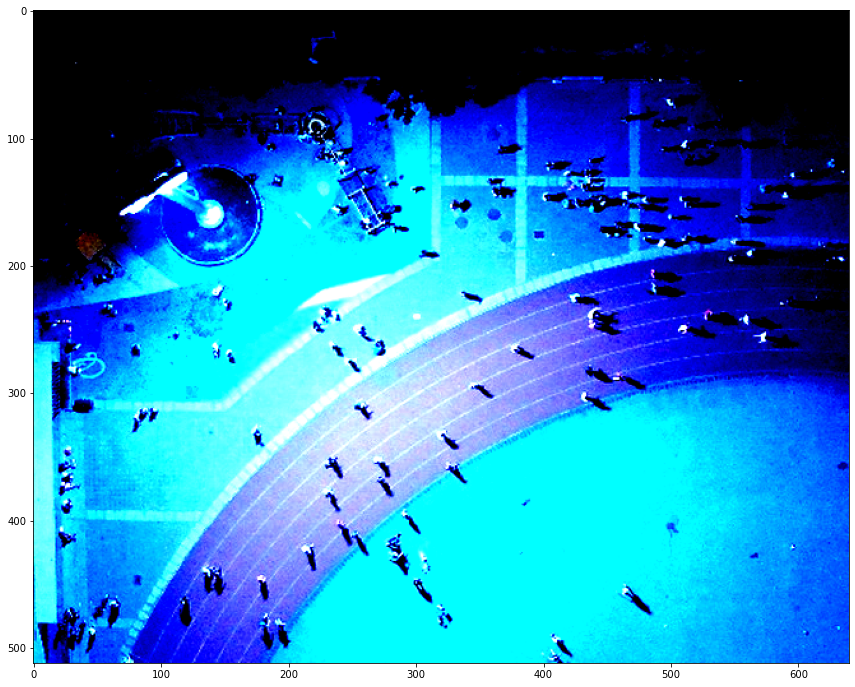

In [244]:
_,ax = plt.subplots(1,1,figsize=(16,12))
ax.imshow(test_frames[0].permute(1,2,0).numpy())

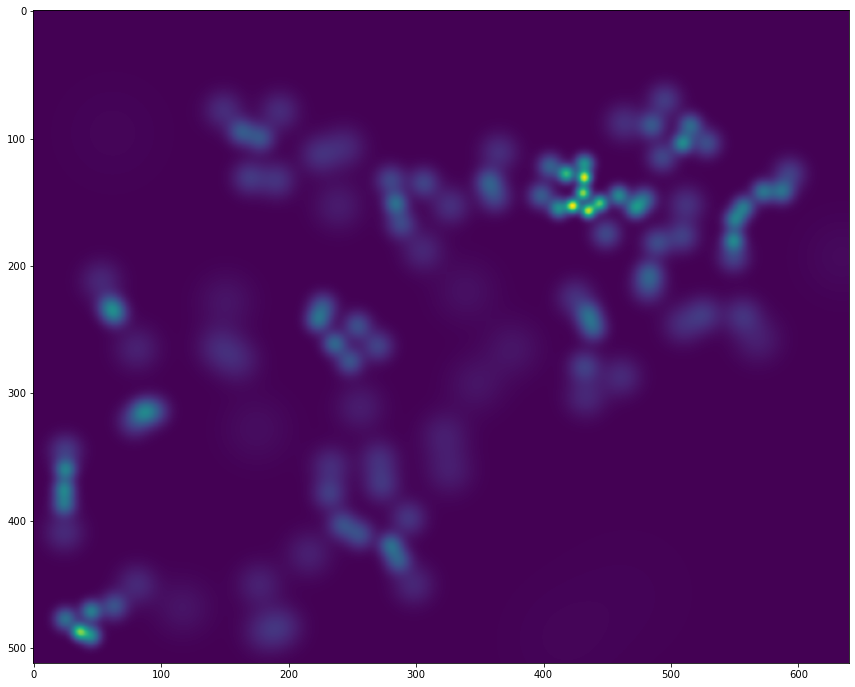

In [243]:
_,ax = plt.subplots(1,1,figsize=(16,12))
ax.imshow(dmaps[0][0].numpy())

In [47]:
test_frames[0].shape

torch.Size([512, 640, 3])

In [74]:
len(frames[0])

16

In [108]:
transform = A.Compose([
    A.HorizontalFlip(p=1.0),
    A.RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2, p=1.0),
#     A.OneOf([
#                 A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
#                                      val_shift_limit=0.2, p=0.9),
#                 A.RandomBrightnessContrast(brightness_limit=0.2, 
#                                            contrast_limit=0.2, p=0.9),
#             ],p=0.9),
    A.Blur(blur_limit=3,p=0.2),
            #A.Normalize(p=1.0,max_pixel_value=1.0),
])

In [35]:
test_frames = np.array(frames[0])
t,h,w,ch = test_frames.shape
test_frames.shape

(16, 512, 640, 3)

In [36]:
np.array(dmaps[0]).shape

(16, 512, 640)

In [141]:
test_image = np.moveaxis(np.moveaxis(test_frames,-1,1).reshape(t*ch,h,w),0,-1)

In [142]:
data = transform(image=test_image)['image']

In [143]:
data = np.moveaxis(np.moveaxis(data,-1,0).reshape(t,ch,h,w),1,-1)

In [144]:
data.shape

(16, 512, 640, 3)

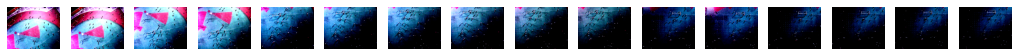

In [37]:
ig, axes = plt.subplots(ncols=16, nrows=1, figsize=(18,12))
for j, x in enumerate(test_frames):
    axes[j].imshow(x)
    #axes[i,j].set_title(ys.item())
    axes[j].axis('off')

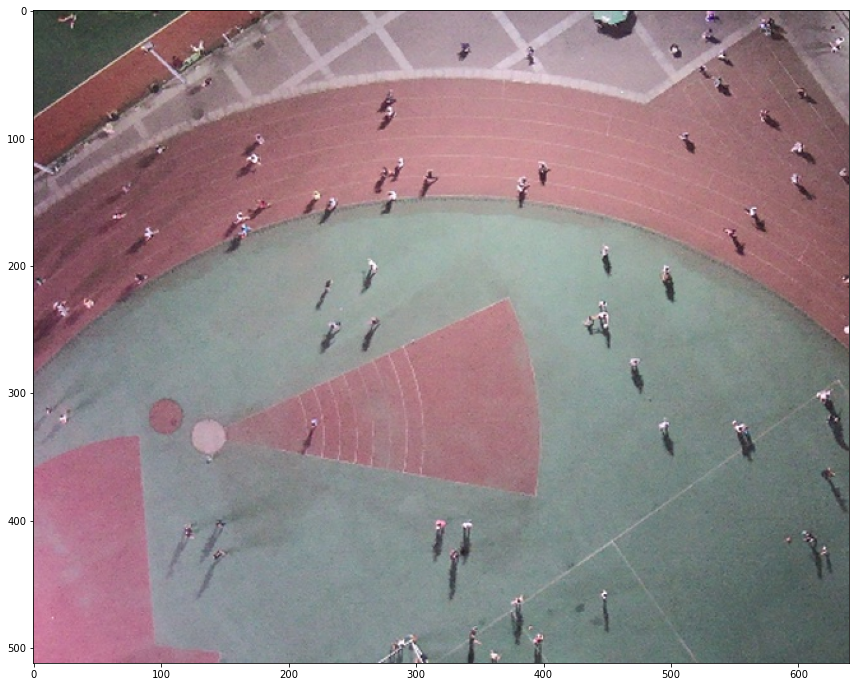

In [38]:
image = cv2.imread(fns[0][0])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
image = image/255.
_,ax = plt.subplots(1,1,figsize=(16,12))
ax.imshow(image)

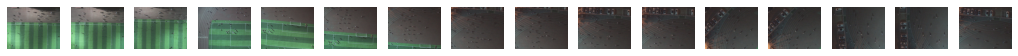

In [147]:
ig, axes = plt.subplots(ncols=16, nrows=1, figsize=(18,12))
for j, x in enumerate(data):
    axes[j].imshow(x)
    #axes[i,j].set_title(ys.item())
    axes[j].axis('off')

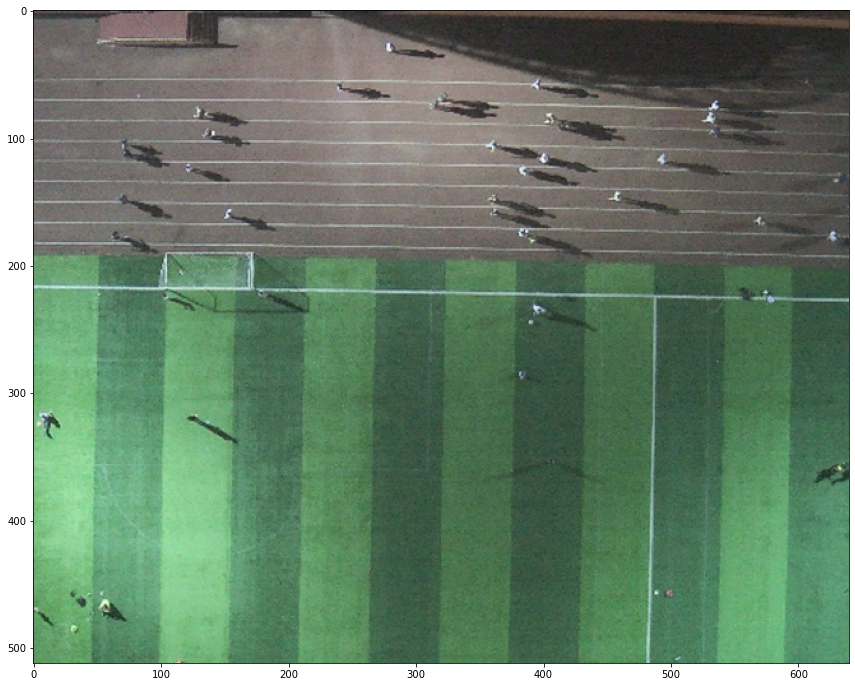

In [148]:
_,ax = plt.subplots(1,1,figsize=(16,12))
ax.imshow(data[0])

In [89]:
%%time
l = []
for i in range(1000):
    l.append(np.random.rand())
l = np.array(l)

CPU times: user 601 µs, sys: 3 µs, total: 604 µs
Wall time: 608 µs


In [91]:
%%time
l = np.array([])
for i in range(1000):
    np.append(l,np.random.rand())


CPU times: user 8.12 ms, sys: 3.82 ms, total: 11.9 ms
Wall time: 8.45 ms
